##### - The idea is to optimize multiple models and use a VotingClassifier to determine the best result.
##### - Models: RandomForestClassifier, GradientBoostingClassifier, SVC

In [32]:
# imports

from imblearn.pipeline import Pipeline  # Note: using the Pipeline from imblearn here.
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
#from sklearn.pipeline import Pipeline # Pipeline from sklearn
from sklearn.compose import ColumnTransformer #possibly for additional preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,PowerTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer

In [33]:
pd.set_option('display.max_colwidth', None) #to display all columns

dataset = load_breast_cancer()
df = pd.DataFrame(dataset["data"],columns=dataset["feature_names"])
df["target"] = dataset["target"]
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [34]:
# in case preprocessing is needed later:
# preprocessor = ColumnTransformer(transformers=[
#     ('num', StandardScaler(), ['feature1', 'feature2', 'feature3']),
#     # Add more transformations here
# ])

In [35]:
# Separate features and target
X = df.drop("target",axis=1)
y = df["target"] 

In [ ]:
# split dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22) #random state for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print(f"Training dataset shape:{X_train.shape}")
print(f"Test dataset shape:{X_test.shape}")

Training dataset shape:(455, 30)
Test dataset shape:(114, 30)


In [37]:
### IMPORTANT: invert logic! 0 = benign, 1 = malignant
y_test = 1 - y_test
y_train = 1 - y_train 


In [38]:
# use half of the available CPU cores
# cpu_cores = int((multiprocessing.cpu_count())/2)
cpu_cores = 8

In [39]:
# SVC
pipeline_svc = Pipeline([("scaler", StandardScaler()),("svc" ,SVC(probability=True))]) #pipeline consisting of scaling and SVC with probability enabled

#all parameters to evaluate (naming syntax scv__xxxxx is important)
param_grid = {
    "scaler" : [StandardScaler(), MinMaxScaler(), RobustScaler(), PowerTransformer(method='yeo-johnson'), "passthrough"],
    'svc__kernel': ['linear', 'rbf'],    
    # 'svc__C': [0.01, 0.05, 0.1, 1, 10, 100, 200, 500], #optionally remove the lower values to avoid overfitting [0.05,0.1, 1, 10, 100, 200]            
    # 'svc__gamma': [50, 20 ,10, 1, 0.1, 0.01, 0.001, 0.0001], #optionally remove the lower values to avoid overfitting [20 ,10, 1, 0.1, 0.01, 0.001]
    'svc__C': [0.1, 1, 10, 100, 200],                 
    'svc__gamma': [10, 1, 0.1, 0.01, 0.001],
    'svc__class_weight': ['balanced', {0:1, 1:1.5}] #[None, 'balanced', {0:1, 1:1.5}]
}

b = 50
fb_scorer = make_scorer(fbeta_score, beta=b)

#or directly optimize with scoring="recall"
gs_svc = GridSearchCV(pipeline_svc, param_grid, scoring=fb_scorer, cv=5, verbose=2, n_jobs=cpu_cores) 
gs_svc.fit(X_train,y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(probability=True))]),
             n_jobs=8,
             param_grid={'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler(), PowerTransformer(),
                                    'passthrough'],
                         'svc__C': [0.1, 1, 10, 100, 200],
                         'svc__class_weight': ['balanced', {0: 1, 1: 1.5}],
                         'svc__gamma': [10, 1, 0.1, 0.01, 0.001],
                         'svc__kernel': ['linear', 'rbf']},
             scoring=make_scorer(fbeta_score, response_method='predict', beta=50),
             verbose=2)

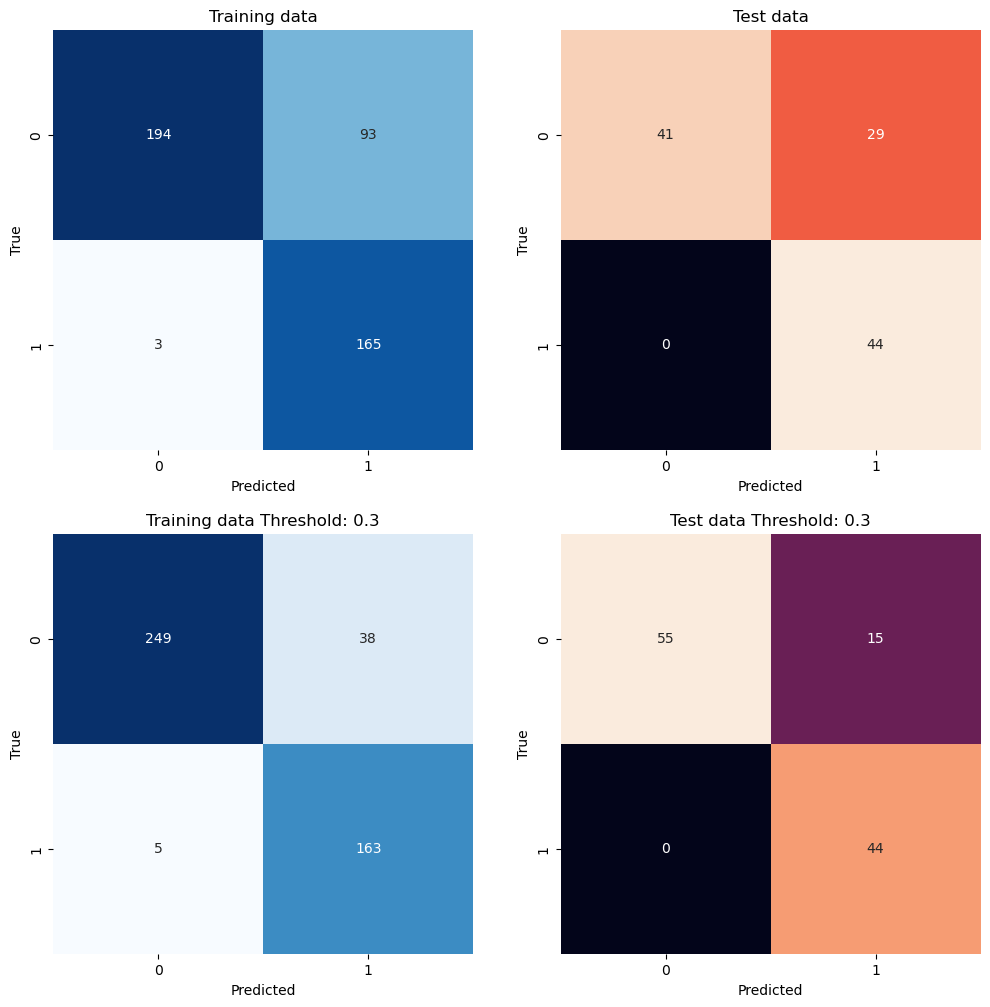

In [40]:
best_SVC = gs_svc.best_estimator_
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

#Training data
SVC_train_pred = best_SVC.predict(X_train)
sns.heatmap(confusion_matrix(y_train, SVC_train_pred), ax=axes[0, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[0, 0].set_title("Training data")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

#Test data
SVC_test_pred = best_SVC.predict(X_test)
sns.heatmap(confusion_matrix(y_test, SVC_test_pred), ax=axes[0, 1], annot=True, fmt="d", cbar=False, square=True)
axes[0, 1].set_title("Test data")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

SVC_threshold = 0.3 ### <-- set threshold
###SVC uses different methods for probability in predict() and predict_proba()
### --> the thresholds are not comparable -> e.g. 0.5 != 0.5


#Training data (Threshold Tuning)
SVC_train_proba = best_SVC.predict_proba(X_train)[:, 1]
SVC_train_proba_pred = (SVC_train_proba >= SVC_threshold).astype(int)
sns.heatmap(confusion_matrix(y_train, SVC_train_proba_pred), ax=axes[1, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[1, 0].set_title(f"Training data Threshold: {SVC_threshold}")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

#Test data (Threshold Tuning)
SVC_test_proba = best_SVC.predict_proba(X_test)[:, 1]
SVC_test_proba_pred = (SVC_test_proba >= SVC_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, SVC_test_proba_pred), ax=axes[1, 1], annot=True, fmt="d", cbar=False, square=True)
axes[1, 1].set_title(f"Test data Threshold: {SVC_threshold}")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

#plt.tight_layout()
plt.show()

### Next: Random Forest 

In [41]:
# Random Forest
pipeline_rf = Pipeline([("rf" ,RandomForestClassifier())]) #the pipeline initially only contains the random forest "rf"

param_grid = {
    'rf__n_estimators': [200, 300, 500], #[100, 200, 300, 500]     # number of trees in the forest
    'rf__max_depth': [10, 20, 30, 40], #None, 50           # maximum depth of individual trees
    'rf__min_samples_split': [5, 10, 20],  #[2, 5, 10]               # minimum number of samples to allow a split
    'rf__min_samples_leaf': [4, 6 ,10],    #[1, 2, 4]          # minimum samples that must be in a leaf
    'rf__max_features': ['sqrt', 'log2'],               # number of features considered at each split
    'rf__bootstrap': [True], #False wegen overfitting entfernt [True, False]   # whether bootstrap samples should be used
    'rf__criterion': ['gini', 'entropy'],                # criterion to measure split quality
    'rf__class_weight': ['balanced', {0:1, 1:1.5}]
}

b = 50
fb_scorer = make_scorer(fbeta_score, beta=b)

#or directly optimize with scoring="recall"
gs_rf = GridSearchCV(pipeline_rf, param_grid, scoring="recall", cv=6, verbose=2, n_jobs=cpu_cores) 
gs_rf.fit(X_train,y_train)

Fitting 6 folds for each of 864 candidates, totalling 5184 fits


GridSearchCV(cv=6, estimator=Pipeline(steps=[('rf', RandomForestClassifier())]),
             n_jobs=8,
             param_grid={'rf__bootstrap': [True],
                         'rf__class_weight': ['balanced', {0: 1, 1: 1.5}],
                         'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [10, 20, 30, 40],
                         'rf__max_features': ['sqrt', 'log2'],
                         'rf__min_samples_leaf': [4, 6, 10],
                         'rf__min_samples_split': [5, 10, 20],
                         'rf__n_estimators': [200, 300, 500]},
             scoring='recall', verbose=2)

In [42]:
print(gs_rf.best_params_)

{'rf__bootstrap': True, 'rf__class_weight': 'balanced', 'rf__criterion': 'gini', 'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 6, 'rf__min_samples_split': 10, 'rf__n_estimators': 300}


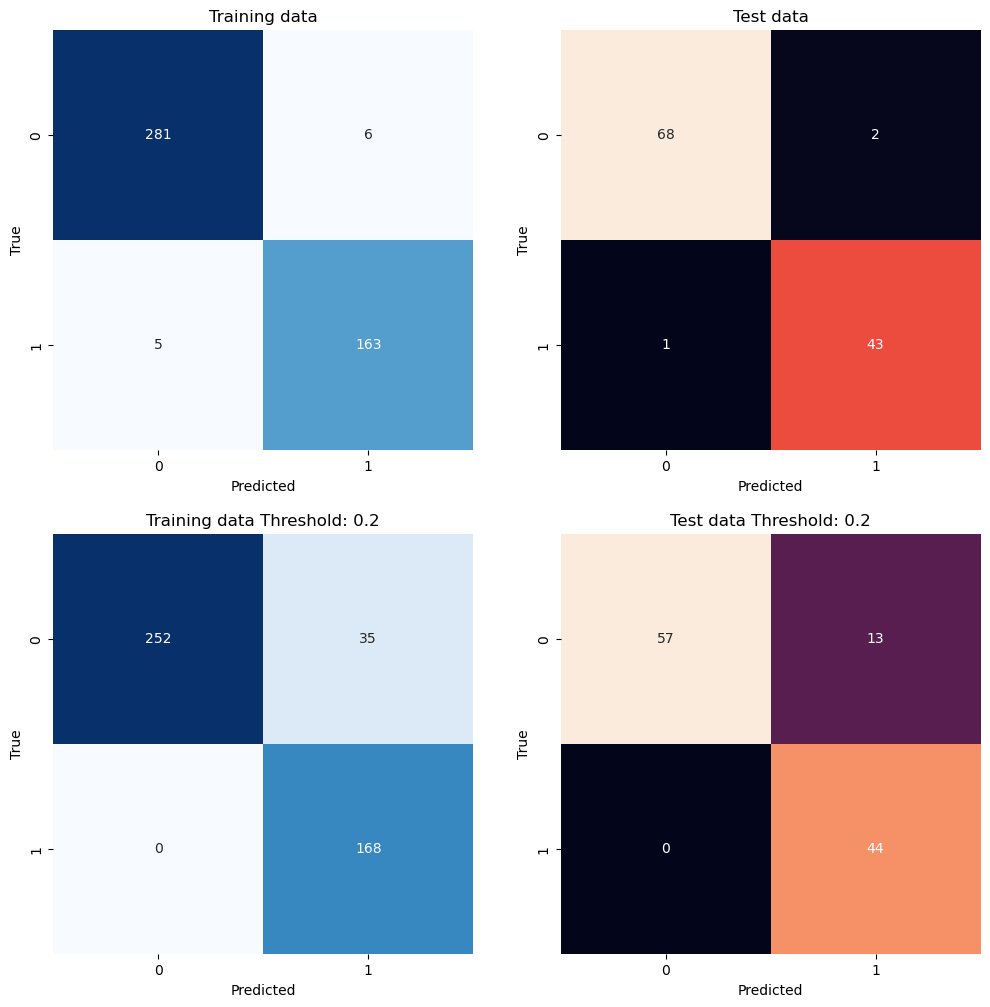

In [43]:
best_RF = gs_rf.best_estimator_
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

#Training data
RF_train_pred = best_RF.predict(X_train)
sns.heatmap(confusion_matrix(y_train, RF_train_pred), ax=axes[0, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[0, 0].set_title("Training data")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

#Test data
RF_test_pred = best_RF.predict(X_test)
sns.heatmap(confusion_matrix(y_test, RF_test_pred), ax=axes[0, 1], annot=True, fmt="d", cbar=False, square=True)
axes[0, 1].set_title("Test data")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

RF_threshold = 0.2 ### <-- set threshold

#Training data (Threshold Tuning)
RF_train_proba = best_RF.predict_proba(X_train)[:, 1]
RF_train_proba_pred = (RF_train_proba >= RF_threshold).astype(int)
sns.heatmap(confusion_matrix(y_train, RF_train_proba_pred), ax=axes[1, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[1, 0].set_title(f"Training data Threshold: {RF_threshold}")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

#Test data (Threshold Tuning)
RF_test_proba = best_RF.predict_proba(X_test)[:, 1]
RF_test_proba_pred = (RF_test_proba >= RF_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, RF_test_proba_pred), ax=axes[1, 1], annot=True, fmt="d", cbar=False, square=True)
axes[1, 1].set_title(f"Test data Threshold: {RF_threshold}")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

#plt.tight_layout()
plt.show()

### And as a third model: a Neural Network (MLP)

In [44]:
# MLP (shallow neural network)
#pipeline = Pipeline([("scaler", StandardScaler()),("mlp" ,MLPClassifier())]) #pipeline consisting of scaling and MLP
pipeline_mlp = Pipeline([("smote", SMOTE()),("scaler", StandardScaler()),("mlp" ,MLPClassifier())]) #pipeline consisting of scaling and MLP

#all parameters to evaluate (naming syntax MLP__xxxxx is important)
param_grid = {
    "smote": [SMOTE(sampling_strategy='auto', random_state=42), "passthrough"], #[SMOTE(sampling_strategy='auto', random_state=42), "passthrough"]
    "scaler": [RobustScaler()], # [StandardScaler(), MinMaxScaler(), RobustScaler()]
    "mlp__hidden_layer_sizes": [(50, 50), (100, 50), (100, 100)], #[(50,), (100,), (50, 50), (100, 50), (100, 100), (100, 50, 25)]
    "mlp__activation": ['relu', 'tanh', 'logistic'],
    "mlp__solver": ['adam', 'sgd','lbfgs'],
    "mlp__alpha": [0.0001, 0.001, 0.01, 0.05],
    "mlp__learning_rate_init": [0.001, 0.01, 0.1, 0.5],
    "mlp__max_iter": [200, 500]
}

b = 50
fb_scorer = make_scorer(fbeta_score, beta=b)



#or directly optimize with scoring="recall"
gs_mlp = GridSearchCV(pipeline_mlp, param_grid, scoring="recall", cv=5, verbose=2, n_jobs=cpu_cores) 
gs_mlp.fit(X_train,y_train)

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


c:\Users\maikn\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('mlp', MLPClassifier())]),
             n_jobs=8,
             param_grid={'mlp__activation': ['relu', 'tanh', 'logistic'],
                         'mlp__alpha': [0.0001, 0.001, 0.01, 0.05],
                         'mlp__hidden_layer_sizes': [(50, 50), (100, 50),
                                                     (100, 100)],
                         'mlp__learning_rate_init': [0.001, 0.01, 0.1, 0.5],
                         'mlp__max_iter': [200, 500],
                         'mlp__solver': ['adam', 'sgd', 'lbfgs'],
                         'scaler': [RobustScaler()],
                         'smote': [SMOTE(random_state=42), 'passthrough']},
             scoring='recall', verbose=2)

In [45]:
print(gs_mlp.best_params_)

{'mlp__activation': 'relu', 'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (100, 100), 'mlp__learning_rate_init': 0.1, 'mlp__max_iter': 200, 'mlp__solver': 'adam', 'scaler': RobustScaler(), 'smote': SMOTE(random_state=42)}


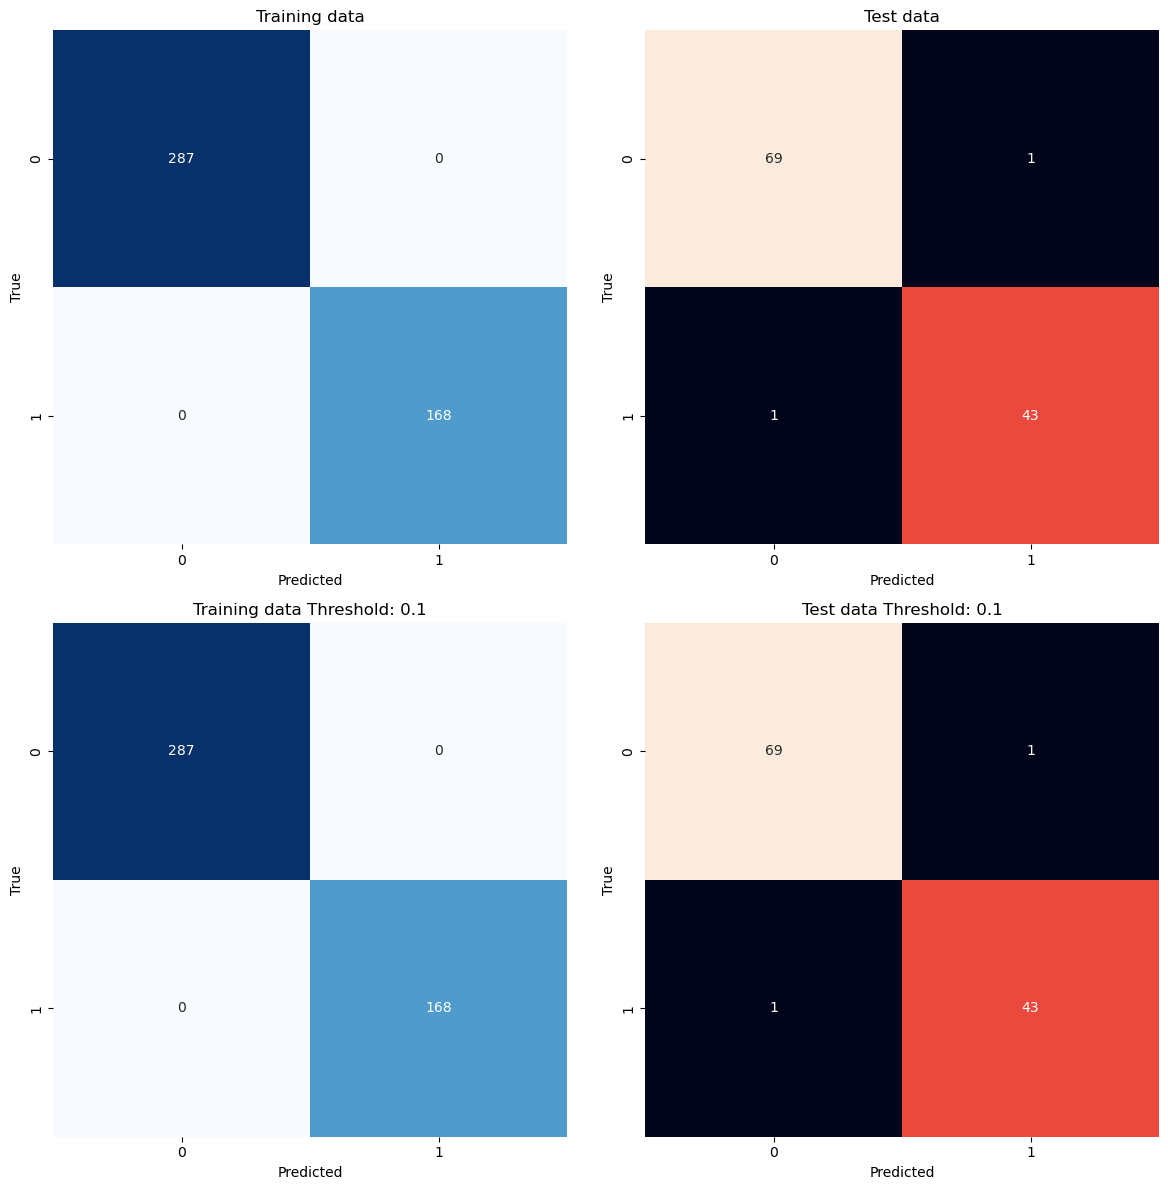

In [46]:
best_MLP = gs_mlp.best_estimator_
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Training data (Default Threshold)
MLP_train_pred = best_MLP.predict(X_train)
sns.heatmap(confusion_matrix(y_train, MLP_train_pred), ax=axes[0, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[0, 0].set_title("Training data")
axes[0, 0].set_xlabel("Predicted")
axes[0, 0].set_ylabel("True")

# Test data (Default Threshold)
MLP_test_pred = best_MLP.predict(X_test)
sns.heatmap(confusion_matrix(y_test, MLP_test_pred), ax=axes[0, 1], annot=True, fmt="d", cbar=False, square=True)
axes[0, 1].set_title("Test data")
axes[0, 1].set_xlabel("Predicted")
axes[0, 1].set_ylabel("True")

MLP_threshold = 0.1  ### <-- set threshold

# Training data (Threshold Tuning)
MLP_train_proba = best_MLP.predict_proba(X_train)[:, 1]
MLP_train_proba_pred = (MLP_train_proba >= MLP_threshold).astype(int)
sns.heatmap(confusion_matrix(y_train, MLP_train_proba_pred), ax=axes[1, 0], cmap='Blues', annot=True, fmt="d", cbar=False, square=True)
axes[1, 0].set_title(f"Training data Threshold: {MLP_threshold}")
axes[1, 0].set_xlabel("Predicted")
axes[1, 0].set_ylabel("True")

# Test data (Threshold Tuning)
MLP_test_proba = best_MLP.predict_proba(X_test)[:, 1]
MLP_test_proba_pred = (MLP_test_proba >= MLP_threshold).astype(int)
sns.heatmap(confusion_matrix(y_test, MLP_test_proba_pred), ax=axes[1, 1], annot=True, fmt="d", cbar=False, square=True)
axes[1, 1].set_title(f"Test data Threshold: {MLP_threshold}")
axes[1, 1].set_xlabel("Predicted")
axes[1, 1].set_ylabel("True")

plt.tight_layout()
plt.show()

In [47]:
# VotingClassifier erstellen – soft voting, damit die Wahrscheinlichkeiten gemittelt werden
voting_clf = VotingClassifier(
    estimators=[
        ("svc", best_SVC),
        ("rf", best_RF),
        ("mlp", best_MLP)
    ],
    voting='soft'
)

# VotingClassifier auf den Training data anpassen
voting_clf.fit(X_train, y_train)

c:\Users\maikn\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('scaler', MinMaxScaler()),
                                              ('svc',
                                               SVC(C=0.1,
                                                   class_weight='balanced',
                                                   gamma=10,
                                                   probability=True))])),
                             ('rf',
                              Pipeline(steps=[('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=30,
                                                                      max_features='log2',
                                                                      min_samples_leaf=6,
                                                                      min_samples_split=10,
                                                                      n_estimators=300))])),
                             ('mlp',
                              Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                              ('scaler', RobustScaler()),
                                              ('mlp',
                                               MLPClassifier(alpha=0.001,
                                                             hidden_layer_sizes=(100,
                                                                                 100),
                                                             learning_rate_init=0.1))]))],
                 voting='soft')

In [48]:
## Voting results for the training data
y_train_pred = voting_clf.predict(X_train)
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       287
           1       1.00      0.98      0.99       168

    accuracy                           0.99       455
   macro avg       0.99      0.99      0.99       455
weighted avg       0.99      0.99      0.99       455

[[287   0]
 [  3 165]]


In [49]:
## Voting results for the test data
y_test_pred = voting_clf.predict(X_test)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        44

    accuracy                           1.00       114
   macro avg       1.00      1.00      1.00       114
weighted avg       1.00      1.00      1.00       114

[[70  0]
 [ 0 44]]


### This is not ideal
#### Thresholds must be taken into account:

SVC threshold: 0.3
RF threshold: 0.2
MLP threshold: 0.1


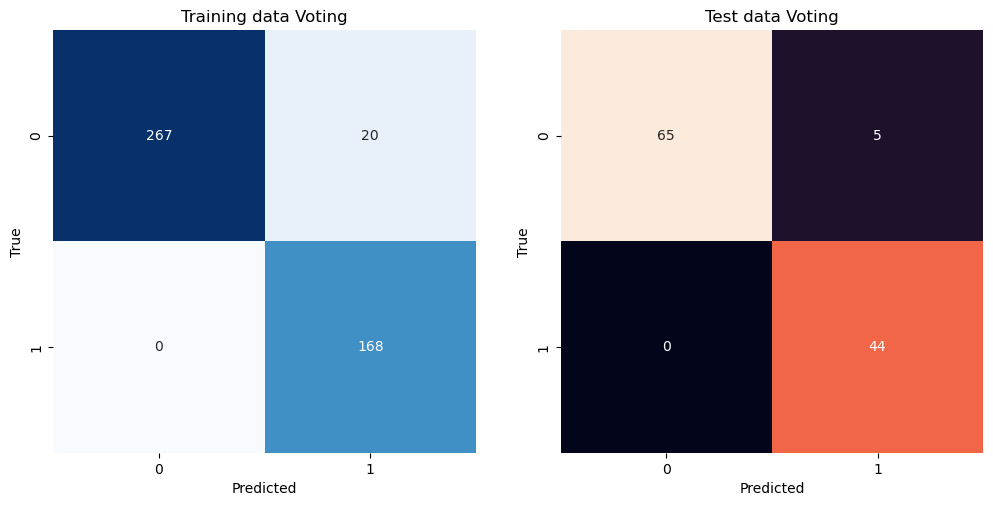

In [50]:
### Basically all required variables have already been calculated:

print(f"SVC threshold: {SVC_threshold}")
print(f"RF threshold: {RF_threshold}")
print(f"MLP threshold: {MLP_threshold}")

# Number of required votes:
s = 2

#für die Training data:
vote_train_pred = (SVC_train_proba_pred + RF_train_proba_pred + MLP_train_proba_pred) >= s
vote_train_pred = vote_train_pred.astype(int)

# für die Test data:
vote_test_pred = (SVC_test_proba_pred + RF_test_proba_pred + MLP_test_proba_pred) >= s
vote_test_pred = vote_test_pred.astype(int)

# confusion matrix:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(confusion_matrix(y_train, vote_train_pred),cmap='Blues', annot=True, fmt="d", cbar=False, square=True, ax=axes[0])
axes[0].set_title("Training data Voting")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test, vote_test_pred), annot=True, fmt="d", cbar=False, square=True, ax=axes[1])
axes[1].set_title("Test data Voting")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()

In [51]:
### Die Wahrscheinlichekeiten addieren und vergleichen:

vote_train_proba = (SVC_train_proba + RF_train_proba + MLP_train_proba) / 3
vote_test_proba = (SVC_test_proba + RF_test_proba + MLP_test_proba) / 3

#First compare the probabilities side by side
df_vote_train_proba = pd.DataFrame({
    "SVC_train_proba": SVC_train_proba,
    "RF_train_proba": RF_train_proba,
    "MLP_train_proba": MLP_train_proba,
    "vote_train_proba": vote_train_proba
})

df_vote_test_proba = pd.DataFrame({
    "SVC_test_proba": SVC_test_proba,
    "RF_test_proba": RF_test_proba,
    "MLP_test_proba": MLP_test_proba,
    "vote_test_proba": vote_test_proba
})


In [52]:
df_vote_train_proba.describe()

,SVC_train_proba,RF_train_proba,MLP_train_proba,vote_train_proba
count,4.550000e+02,455.000000,4.550000e+02,4.550000e+02
mean,3.972837e-01,0.385591,3.692485e-01,3.840412e-01
std,4.331356e-01,0.425996,4.829503e-01,4.379342e-01
min,1.000000e-07,0.000000,9.729530e-85,4.109134e-07
25%,5.965676e-04,0.013687,5.430147e-22,6.300118e-03
50%,1.080270e-01,0.105714,3.436019e-10,9.342439e-02
75%,9.267374e-01,0.924851,1.000000e+00,9.572441e-01
max,9.955782e-01,1.000000,1.000000e+00,9.976228e-01


In [53]:
df_vote_test_proba.describe()

,SVC_test_proba,RF_test_proba,MLP_test_proba,vote_test_proba
count,1.140000e+02,114.000000,1.140000e+02,114.000000
mean,4.305128e-01,0.415040,3.860702e-01,0.410541
std,4.083947e-01,0.434150,4.888884e-01,0.425445
min,1.607338e-07,0.000000,8.026742e-96,0.000027
25%,1.422042e-03,0.013130,1.588346e-25,0.009698
50%,4.080560e-01,0.198018,3.175128e-11,0.205007
75%,8.465089e-01,0.972639,1.000000e+00,0.916074
max,9.947755e-01,1.000000,1.000000e+00,0.997888


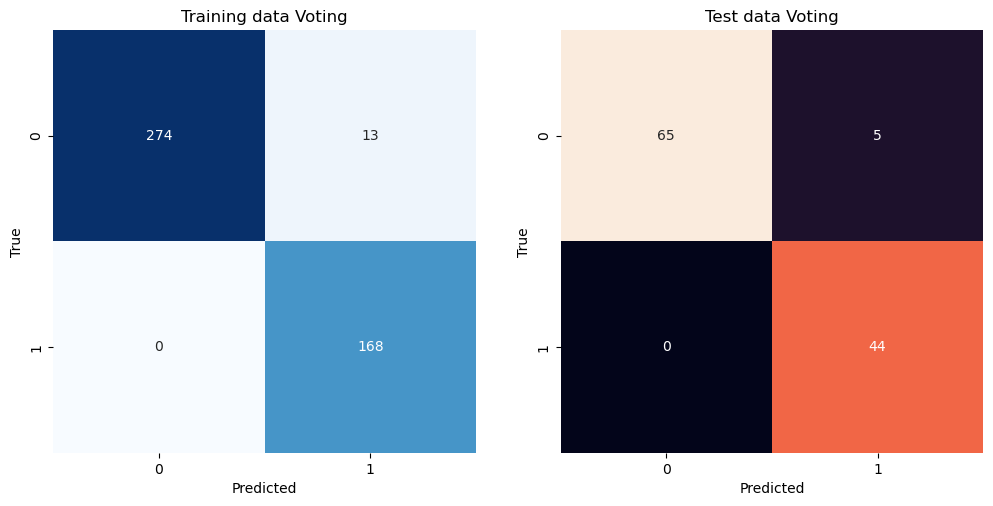

In [54]:
### now apply thresholds for the overall probability in a confusion matrix:

#threshold
S = 0.3

#calculate predictions:
vote_train_proba_pred = vote_train_proba >= S
vote_train_proba_pred = vote_train_proba_pred.astype(int)

vote_test_proba_pred = vote_test_proba >= S
vote_test_proba_pred = vote_test_proba_pred.astype(int)


# confusion matrix:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(confusion_matrix(y_train, vote_train_proba_pred),cmap='Blues', annot=True, fmt="d", cbar=False, square=True, ax=axes[0])
axes[0].set_title("Training data Voting")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_test, vote_test_proba_pred), annot=True, fmt="d", cbar=False, square=True, ax=axes[1])
axes[1].set_title("Test data Voting")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.show()

In [55]:
# DataFrame with all training predictions:
df_all_train_predictions = pd.DataFrame({
    "SVC_train_pred": SVC_train_pred,
    "RF_train_pred": RF_train_pred,
    "MLP_train_pred": MLP_train_pred,
    "SVC_train_proba_pred": SVC_train_proba_pred,
    "RF_train_proba_pred": RF_train_proba_pred,
    "MLP_train_proba_pred": MLP_train_proba_pred,
    "vote_train_pred": vote_train_pred,
    "SVC_train_proba": SVC_train_proba,
    "RF_train_proba": RF_train_proba,
    "MLP_train_proba": MLP_train_proba,
    "vote_train_proba": vote_train_proba,
    "vote_train_proba_pred": vote_train_proba_pred,
    "TARGET": y_train
}) 

# DataFrame with all test predictions:
df_all_test_predictions = pd.DataFrame({
    "SVC_test_pred": SVC_test_pred,
    "RF_test_pred": RF_test_pred,
    "MLP_test_pred": MLP_test_pred,
    "SVC_test_proba_pred": SVC_test_proba_pred,
    "RF_test_proba_pred": RF_test_proba_pred,
    "MLP_test_proba_pred": MLP_test_proba_pred,
    "vote_test_pred": vote_test_pred,
    "SVC_test_proba": SVC_test_proba,
    "RF_test_proba": RF_test_proba,
    "MLP_test_proba": MLP_test_proba,
    "vote_test_proba": vote_test_proba,
    "vote_test_proba_pred": vote_test_proba_pred,
    "TARGET": y_test
})


In [56]:
print(f"SVC threshold: {SVC_threshold}")
print(f"RF threshold: {RF_threshold}")
print(f"MLP threshold: {MLP_threshold}")

print(f"s (number of required votes) is: {s}")
print(f"S (threshold for probabilities) is: {S}")

df_all_train_predictions.head(20)

SVC threshold: 0.3
RF threshold: 0.2
MLP threshold: 0.1
s (number of required votes) is: 2
S (threshold for probabilities) is: 0.3


,SVC_train_pred,RF_train_pred,MLP_train_pred,SVC_train_proba_pred,RF_train_proba_pred,MLP_train_proba_pred,vote_train_pred,SVC_train_proba,RF_train_proba,MLP_train_proba,vote_train_proba,vote_train_proba_pred,TARGET
459,1,0,0,0,0,0,0,0.101229,0.014195,1.337626e-07,0.038475,0,0
238,1,0,0,1,1,0,1,0.465458,0.290510,7.344759e-06,0.251992,0,0
158,0,0,0,0,0,0,0,0.000002,0.005136,1.196813e-19,0.001713,0,0
153,0,0,0,0,0,0,0,0.000075,0.004236,3.331906e-35,0.001437,0,0
132,1,1,1,1,1,1,1,0.988117,0.982200,1.000000e+00,0.990105,1,1
148,1,0,0,0,1,0,0,0.041156,0.427608,1.080665e-08,0.156255,0,0
205,1,1,1,1,1,1,1,0.625805,0.787281,9.999044e-01,0.804330,1,1
286,0,0,0,0,0,0,0,0.022415,0.063442,1.474429e-31,0.028619,0,0
292,0,0,0,0,0,0,0,0.000073,0.017919,2.957250e-38,0.005997,0,0
27,1,1,1,1,1,1,1,0.988127,0.996352,1.000000e+00,0.994826,1,1


In [57]:
df_train_abweichungen = df_all_train_predictions[df_all_train_predictions["vote_train_proba_pred"] != df_all_train_predictions["TARGET"]]
df_train_abweichungen

,SVC_train_pred,RF_train_pred,MLP_train_pred,SVC_train_proba_pred,RF_train_proba_pred,MLP_train_proba_pred,vote_train_pred,SVC_train_proba,RF_train_proba,MLP_train_proba,vote_train_proba,vote_train_proba_pred,TARGET
413,1,0,0,1,1,0,1,0.540866,0.410186,1.011143e-05,0.317021,1,0
421,1,1,0,1,1,0,1,0.525249,0.510086,1.941604e-06,0.345112,1,0
68,1,0,0,1,1,0,1,0.593039,0.328929,7.262879e-56,0.307323,1,0
112,1,1,0,1,1,0,1,0.594958,0.577026,4.507189e-51,0.390661,1,0
157,1,1,0,1,1,0,1,0.506025,0.582334,3.861454e-11,0.362787,1,0
363,1,1,0,1,1,0,1,0.415463,0.521977,2.569758e-08,0.312480,1,0
152,1,0,0,1,1,0,1,0.593046,0.371766,9.729530e-85,0.321604,1,0
128,1,0,0,1,1,0,1,0.491966,0.474444,1.023475e-05,0.322140,1,0
81,1,0,0,1,1,0,1,0.890112,0.494826,3.712029e-05,0.461658,1,0
541,1,0,0,1,1,0,1,0.739199,0.471954,8.694859e-04,0.404007,1,0


In [58]:
print(f"SVC threshold: {SVC_threshold}")
print(f"RF threshold: {RF_threshold}")
print(f"MLP threshold: {MLP_threshold}")

print(f"s (number of required votes) is: {s}")
print(f"S (threshold for probabilities) is: {S}")

df_all_test_predictions.head(20)

SVC threshold: 0.3
RF threshold: 0.2
MLP threshold: 0.1
s (number of required votes) is: 2
S (threshold for probabilities) is: 0.3


,SVC_test_pred,RF_test_pred,MLP_test_pred,SVC_test_proba_pred,RF_test_proba_pred,MLP_test_proba_pred,vote_test_pred,SVC_test_proba,RF_test_proba,MLP_test_proba,vote_test_proba,vote_test_proba_pred,TARGET
547,0,0,0,0,0,0,0,2.770140e-04,0.000532,5.989127e-46,0.000270,0,0
222,0,0,0,0,0,0,0,7.952757e-05,0.000000,4.315933e-38,0.000027,0,0
218,1,1,1,1,1,1,1,9.819494e-01,1.000000,1.000000e+00,0.993983,1,1
50,0,0,0,0,0,0,0,6.183872e-05,0.024081,5.167328e-11,0.008048,0,0
199,1,1,1,1,1,1,1,9.676887e-01,0.911159,1.000000e+00,0.959616,1,1
368,1,1,1,1,1,1,1,7.656994e-01,0.977579,1.000000e+00,0.914426,1,1
316,0,0,0,0,0,0,0,1.066934e-03,0.009856,4.349566e-30,0.003641,0,0
406,0,1,0,0,1,0,0,1.592415e-02,0.616830,4.951746e-15,0.210918,0,0
518,1,0,0,0,1,0,0,1.265623e-01,0.207765,4.798579e-04,0.111602,0,0
176,1,0,0,1,0,0,0,7.219366e-01,0.092338,2.211229e-60,0.271425,0,0


In [59]:
df_test_abweichungen = df_all_test_predictions[df_all_test_predictions["vote_test_proba_pred"] != df_all_test_predictions["TARGET"]]
df_test_abweichungen

,SVC_test_pred,RF_test_pred,MLP_test_pred,SVC_test_proba_pred,RF_test_proba_pred,MLP_test_proba_pred,vote_test_pred,SVC_test_proba,RF_test_proba,MLP_test_proba,vote_test_proba,vote_test_proba_pred,TARGET
410,0,0,1,0,0,1,0,0.031728,0.033120,9.999760e-01,0.354942,1,0
247,1,0,0,1,1,0,1,0.681597,0.374172,1.433241e-31,0.351923,1,0
376,1,0,0,1,1,0,1,0.714840,0.356572,7.876767e-67,0.357137,1,0
290,1,0,0,1,1,0,1,0.728319,0.452086,1.347304e-53,0.393468,1,0
485,1,0,0,1,1,0,1,0.686528,0.286556,1.724964e-44,0.324362,1,0
